In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns

In [3]:
spark = SparkSession.builder \
    .appName("Analyse Immatriculations") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [4]:
spark.sql("USE concessionnaire")
client_immat_df = spark.sql("SELECT * FROM client_immatriculation_merged")

nombre_total_lignes = client_immat_df.count()
print(nombre_total_lignes)
client_immat_df.show(10)

98834
+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+
|immatriculation|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture| marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|   prix|modele|
+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+
|        0 OG 13| 56|Homme| 528|        Célibataire|              0|          false|   Audi|       75|     courte|       5|       5|  blanc|    true|12817.0|    A2|
|        0 OZ 65| 32|Homme| 563|          En Couple|              2|          false|   Ford|      125|     longue|       5|       5|  blanc|   false|23900.0|Mondeo|
|        1 PD 24| 28|Homme| 230|          En Couple|              2|          false|Renault|      245|très longue|       5|       5|  blanc|    true|34440.0|   Vel|
|   

# Vérification des nuls

In [8]:
null_counts = {column: client_immat_df.filter(F.col(column).isNull()).count() for column in client_immat_df.columns}
print(null_counts)

client_immat_df.describe().show()

client_immat_df.describe(["prix", "puissance"]).show()

{'immatriculation': 0, 'age': 0, 'sexe': 0, 'taux': 0, 'situationfamilliale': 0, 'nbenfantacharge': 0, 'deuxiemevoiture': 0, 'marque': 0, 'puissance': 0, 'longueur': 0, 'nbplaces': 0, 'nbportes': 0, 'couleur': 0, 'occasion': 0, 'prix': 0, 'modele': 0}
+-------+---------------+------------------+-----+-----------------+-------------------+------------------+---------------+------+------------------+-----------+--------+-------------------+-------+-----------------+-----------------+
|summary|immatriculation|               age| sexe|             taux|situationfamilliale|   nbenfantacharge|deuxiemevoiture|marque|         puissance|   longueur|nbplaces|           nbportes|couleur|             prix|           modele|
+-------+---------------+------------------+-----+-----------------+-------------------+------------------+---------------+------+------------------+-----------+--------+-------------------+-------+-----------------+-----------------+
|  count|          98834|             98834

# Vérifications des valeurs de Age

In [7]:
client_immat_df.select("age").distinct().orderBy('age').show(100)

+---+
|age|
+---+
| 18|
| 19|
| 20|
| 21|
| 22|
| 23|
| 24|
| 25|
| 26|
| 27|
| 28|
| 29|
| 30|
| 31|
| 32|
| 33|
| 34|
| 35|
| 36|
| 37|
| 38|
| 39|
| 40|
| 41|
| 42|
| 43|
| 44|
| 45|
| 46|
| 47|
| 48|
| 49|
| 50|
| 51|
| 52|
| 53|
| 54|
| 55|
| 56|
| 57|
| 58|
| 59|
| 60|
| 61|
| 62|
| 63|
| 64|
| 65|
| 66|
| 67|
| 68|
| 69|
| 70|
| 71|
| 72|
| 73|
| 74|
| 75|
| 76|
| 77|
| 78|
| 79|
| 80|
| 81|
| 82|
| 83|
| 84|
+---+



# Vérification des valeurs de Marque

In [13]:
client_immat_df.select("marque").distinct().show()

+----------+
|    marque|
+----------+
|Volkswagen|
|   Peugeot|
|    Jaguar|
|    Lancia|
|      Mini|
|       Kia|
|     Volvo|
|      Saab|
|      Audi|
|      Seat|
|  Mercedes|
|   Renault|
|       BMW|
|     Dacia|
|     Skoda|
|  Daihatsu|
|    Nissan|
|      Fiat|
|      Ford|
+----------+



# Vérification des valeurs de Modele

In [14]:
client_immat_df.select("modele").distinct().show(1000)

+-------+
| modele|
+-------+
| Copper|
|   Golf|
| X-Type|
|     A2|
| Mondeo|
|    S80|
|   1007|
|  Logan|
|  Croma|
|   Polo|
|    Vel|
| Toledo|
|Ypsilon|
|  Cuore|
| Laguna|
|     M5|
| Maxima|
| Megane|
|   A200|
|   120i|
|   S500|
|Picanto|
| Almera|
|    9.3|
|    New|
|Primera|
|     A3|
| Superb|
+-------+



# Vérification des valeurs de longeur

In [15]:
client_immat_df.select("longueur").distinct().show()

+-----------+
|   longueur|
+-----------+
|    moyenne|
|très longue|
|     courte|
|     longue|
+-----------+



In [6]:
# Doublon à fix
immatriculation_counts = client_immat_df.groupBy("Immatriculation").agg(F.count("*").alias("occurences"))
doublons_immatriculation = immatriculation_counts.filter(F.col("occurences") > 1)

doublons_immatriculation.show(truncate=False)

doublons_list = [row["Immatriculation"] for row in doublons_immatriculation.collect()]
doublons_lignes = client_immat_df.filter(F.col("Immatriculation").isin(doublons_list))

doublons_lignes.show(truncate=False)

+---------------+-----------------+
|Immatriculation|nombre_occurences|
+---------------+-----------------+
+---------------+-----------------+

+---------------+---+----+----+-------------------+---------------+---------------+------+---------+--------+--------+--------+-------+--------+----+------+
|immatriculation|age|sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|marque|puissance|longueur|nbplaces|nbportes|couleur|occasion|prix|modele|
+---------------+---+----+----+-------------------+---------------+---------------+------+---------+--------+--------+--------+-------+--------+----+------+
+---------------+---+----+----+-------------------+---------------+---------------+------+---------+--------+--------+--------+-------+--------+----+------+



In [8]:
distribution_vehicules = client_immat_df.groupBy("situationfamilliale", "modele").agg(F.count("*").alias("nombre_vehicules"))
distribution_vehicules.orderBy(F.desc("nombre_vehicules")).show()



+-------------------+------+----------------+
|situationfamilliale|modele|nombre_vehicules|
+-------------------+------+----------------+
|          En Couple|    M5|           12126|
|        Célibataire|    A2|           10119|
|          En Couple|X-Type|            8081|
|          En Couple|   S80|            5767|
|          En Couple|   Vel|            5608|
|          En Couple|  S500|            4835|
|          En Couple|    A2|            3938|
|          En Couple|   9.3|            3580|
|          En Couple| Croma|            3230|
|          En Couple|Mondeo|            3210|
|          En Couple|Laguna|            3116|
|        Célibataire|  Polo|            3052|
|        Célibataire|  1007|            2872|
|        Célibataire|  Golf|            2574|
|        Célibataire|Megane|            2560|
|        Célibataire|  A200|            2203|
|        Célibataire|  120i|            1906|
|          En Couple|  Polo|            1780|
|          En Couple|  1007|      

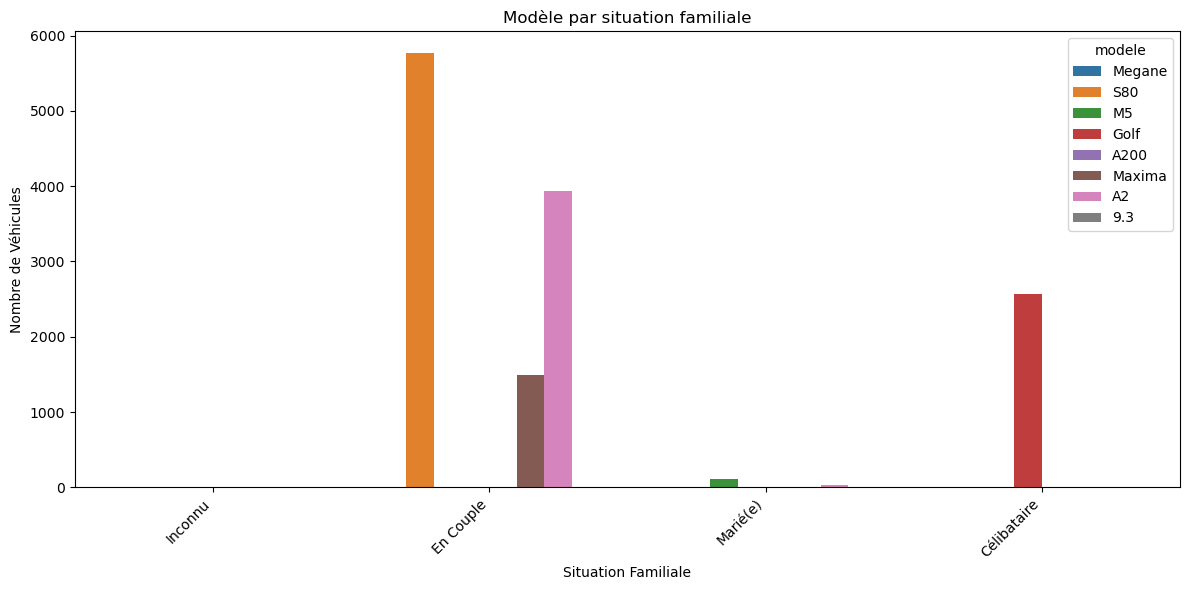

In [9]:
distribution_vehicules_pandas = distribution_vehicules.toPandas()
top_10_distribution = distribution_vehicules_pandas.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_distribution, x='situationfamilliale', y='nombre_vehicules', hue='modele')

plt.xlabel('Situation Familiale')
plt.ylabel('Nombre de Véhicules')
plt.title('Modèle par situation familiale')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [10]:
# Calculer la puissance moyenne par situation familiale
puissance_moyenne_par_situation = client_immat_df.groupBy("situationfamilliale").agg(F.avg("puissance").alias("puissance_moyenne"))
puissance_moyenne_par_situation.show()


+-------------------+------------------+
|situationfamilliale| puissance_moyenne|
+-------------------+------------------+
|        Célibataire|115.08338634129416|
|           Divorcée| 237.2622950819672|
|            Inconnu|206.96715328467153|
|          En Couple|245.52571500845838|
|           Marié(e)|240.39285714285714|
+-------------------+------------------+



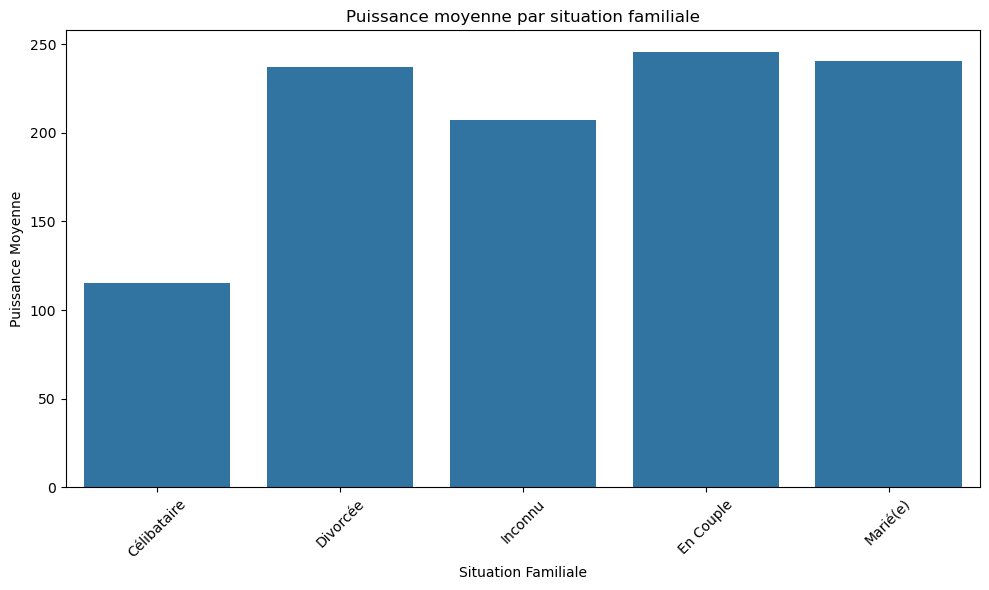

In [11]:
puissance_moyenne_par_situation_pandas = puissance_moyenne_par_situation.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=puissance_moyenne_par_situation_pandas, x="situationfamilliale", y="puissance_moyenne")
plt.xlabel('Situation Familiale')
plt.ylabel('Puissance Moyenne')
plt.title('Puissance moyenne par situation familiale')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+---------------+-----------------+
|    tranche_age|       prix_moyen|
+---------------+-----------------+
|      30-39 ans|35208.05542891422|
|      40-59 ans|35145.70614353027|
| 60 ans et plus|38415.10159392982|
|Moins de 30 ans|35466.59208870446|
+---------------+-----------------+



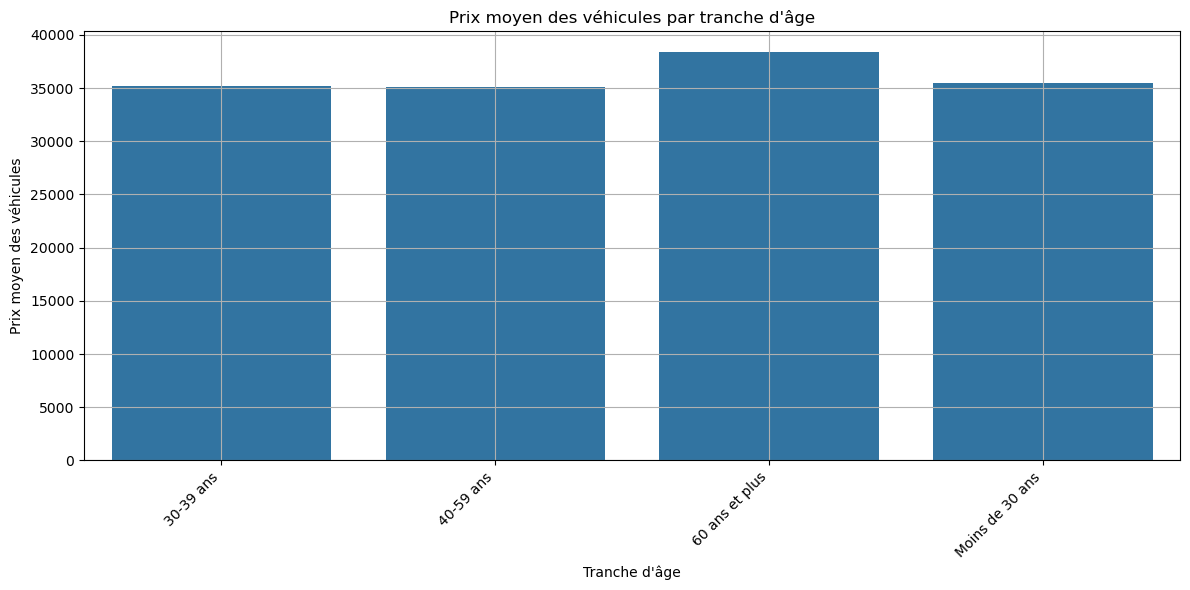

In [12]:
client_immat_df = client_immat_df.withColumn("tranche_age",
                                             F.when(F.col("age") < 30, "Moins de 30 ans")
                                             .when((F.col("age") >= 30) & (F.col("age") < 40), "30-39 ans")
                                             .when((F.col("age") >= 40) & (F.col("age") < 60), "40-59 ans")
                                             .otherwise("60 ans et plus"))

prix_moyen_par_tranche_age = client_immat_df.groupBy("tranche_age").agg(F.avg("prix").alias("prix_moyen"))

prix_moyen_par_tranche_age = prix_moyen_par_tranche_age.orderBy(F.col("tranche_age"))

prix_moyen_par_tranche_age.show()

prix_moyen_par_tranche_age_pandas = prix_moyen_par_tranche_age.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=prix_moyen_par_tranche_age_pandas, x="tranche_age", y="prix_moyen")

plt.xlabel("Tranche d'âge")
plt.ylabel("Prix moyen des véhicules")
plt.title("Prix moyen des véhicules par tranche d'âge")
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True)
plt.tight_layout()

plt.show()

+----+------------------+
|taux|puissance_moyenne |
+----+------------------+
|150 |146.07655502392345|
|151 |142.12244897959184|
|152 |143.1657754010695 |
|153 |154.22680412371133|
|154 |140.5923913043478 |
|155 |145.82882882882882|
|156 |144.5336787564767 |
|157 |140.77835051546393|
|158 |153.8148148148148 |
|159 |145.93034825870646|
|160 |157.75675675675674|
|161 |137.89            |
|162 |134.07070707070707|
|163 |149.61951219512196|
|164 |141.22488038277513|
|165 |149.9625668449198 |
|166 |146.45108695652175|
|167 |148.3422459893048 |
|168 |143.45054945054946|
|169 |139.86010362694302|
+----+------------------+
only showing top 20 rows



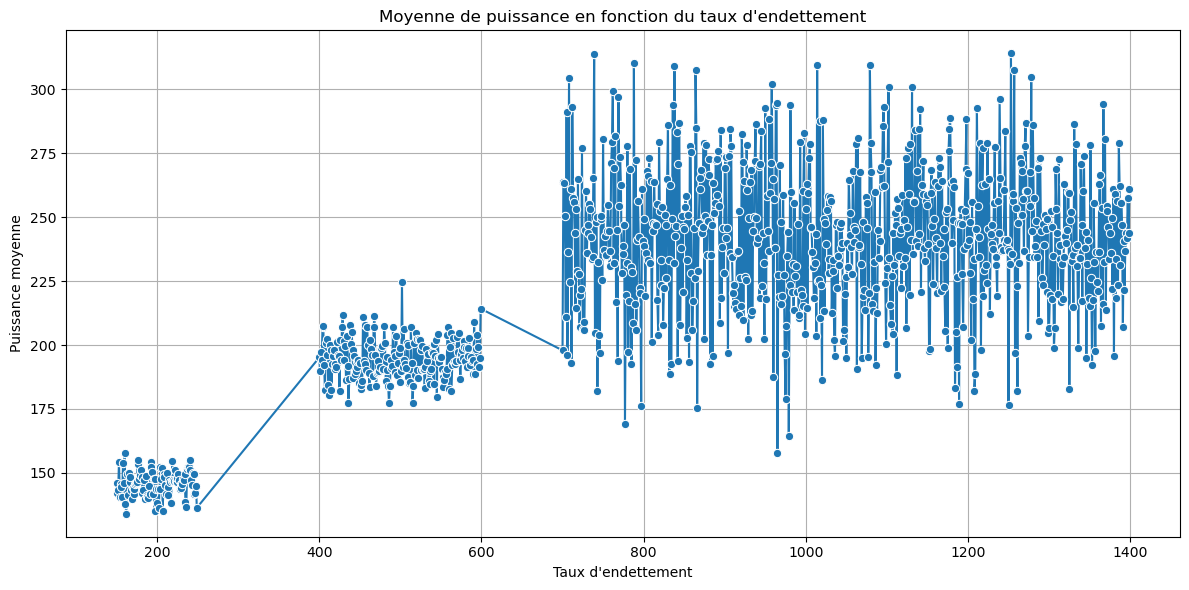

In [13]:
puissance_par_taux = client_immat_df.groupBy("taux").agg(F.avg("puissance").alias("puissance_moyenne"))
puissance_par_taux.orderBy("taux").show(truncate=False)

puissance_par_taux_pandas = puissance_par_taux.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(data=puissance_par_taux_pandas, x="taux", y="puissance_moyenne", marker="o")
plt.xlabel("Taux d'endettement")
plt.ylabel("Puissance moyenne")
plt.title("Moyenne de puissance en fonction du taux d'endettement")
plt.grid(visible=True)
plt.tight_layout()

plt.show()

+-----+-----------------+
| sexe|       prix_moyen|
+-----+-----------------+
|Femme|36233.97142566606|
|Homme| 35759.8511411836|
+-----+-----------------+



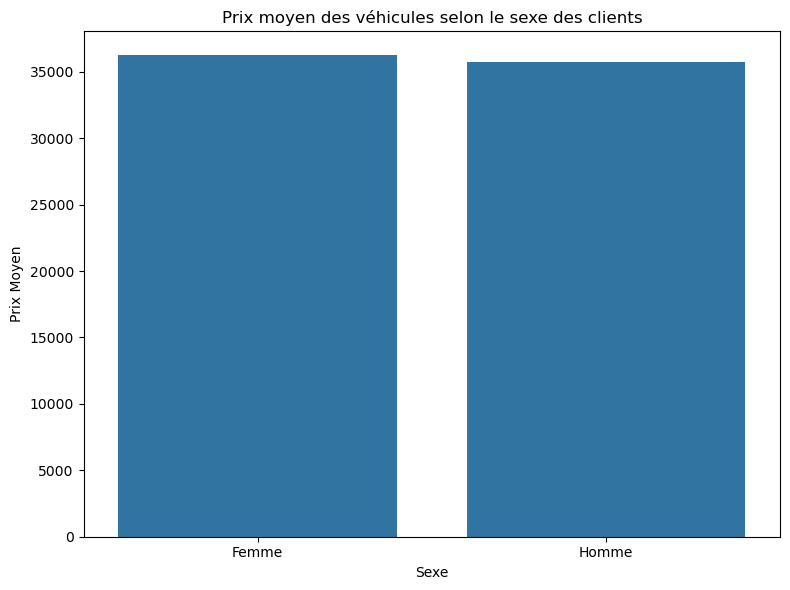

In [16]:
# Calculer le prix moyen des véhicules selon le sexe des clients
prix_moyen_par_sexe = client_immat_df.groupBy("sexe").agg(F.avg("prix").alias("prix_moyen"))
prix_moyen_par_sexe.show()

# Visualiser la différence de prix moyen entre les sexes
prix_moyen_par_sexe_pandas = prix_moyen_par_sexe.toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(data=prix_moyen_par_sexe_pandas, x="sexe", y="prix_moyen")
plt.xlabel("Sexe")
plt.ylabel("Prix Moyen")
plt.title("Prix moyen des véhicules selon le sexe des clients")
plt.tight_layout()
plt.show()


+-------------------+---------------+
|situationfamilliale|nb_places_moyen|
+-------------------+---------------+
|        Célibataire|            5.0|
|           Divorcée|            5.0|
|            Inconnu|            5.0|
|          En Couple|            5.0|
|           Marié(e)|            5.0|
+-------------------+---------------+



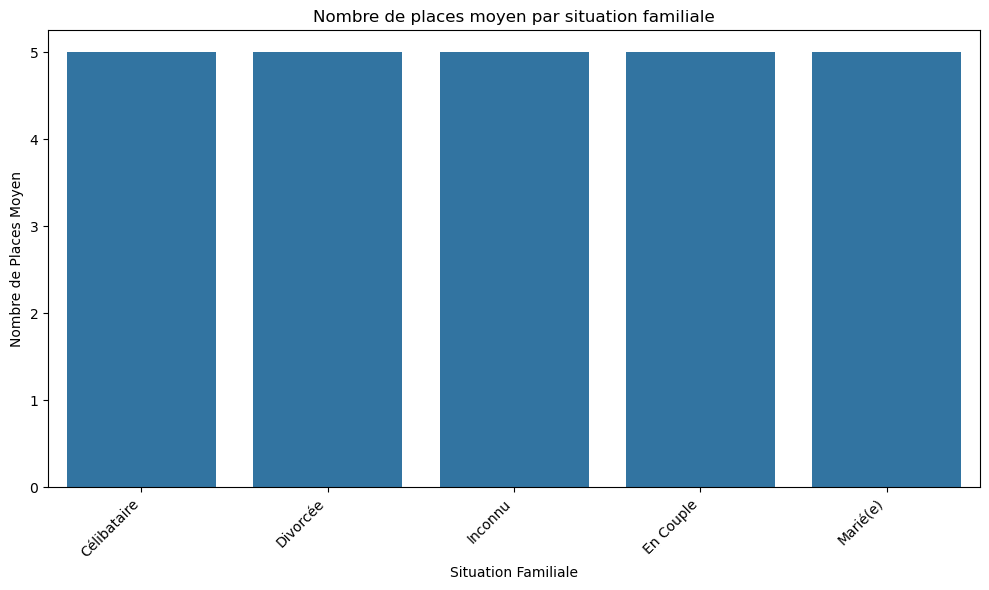

In [18]:
# Nombre moyen de places par situation familiale
nb_places_moyen_par_situation = client_immat_df.groupBy("situationfamilliale").agg(F.avg("nbplaces").alias("nb_places_moyen"))
nb_places_moyen_par_situation.show()

# Visualisation du nombre de places moyen par situation familiale
nb_places_moyen_par_situation_pandas = nb_places_moyen_par_situation.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=nb_places_moyen_par_situation_pandas, x="situationfamilliale", y="nb_places_moyen")
plt.xlabel("Situation Familiale")
plt.ylabel("Nombre de Places Moyen")
plt.title("Nombre de places moyen par situation familiale")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


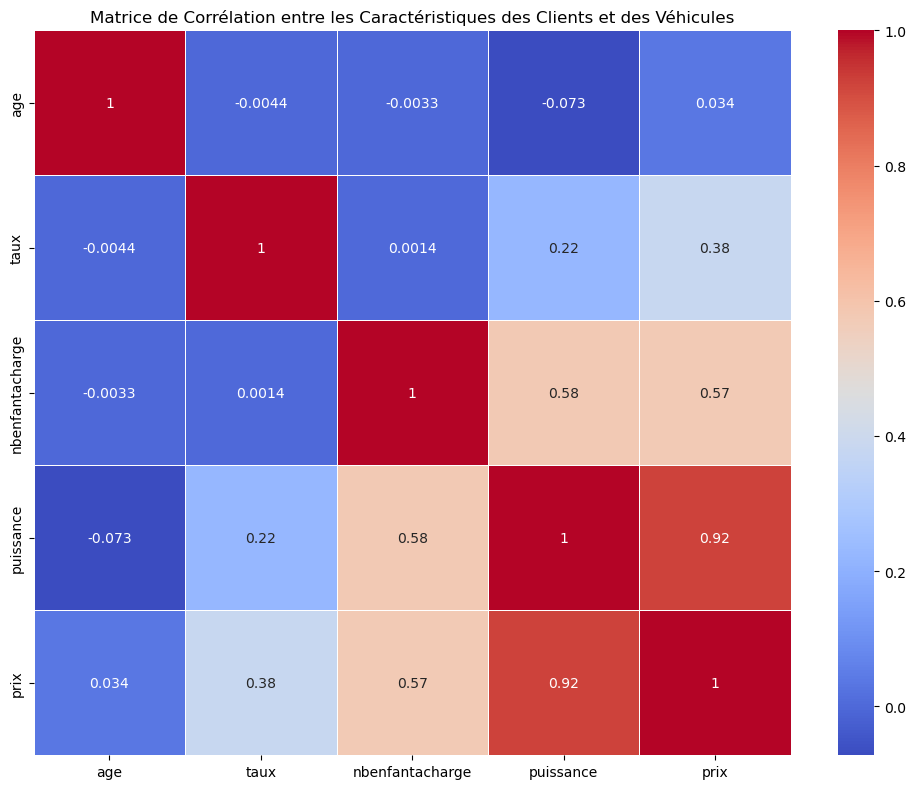

In [24]:
numerical_columns = ["age", "taux", "nbenfantacharge", "puissance", "prix"]
numerical_df = client_immat_df.select(numerical_columns)

numerical_df_pandas = numerical_df.toPandas()

# Calculer la matrice de corrélation
corr_matrix = numerical_df_pandas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation entre les Caractéristiques des Clients et des Véhicules")
plt.tight_layout()
plt.show()

In [69]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

numerical_columns = ["age", "taux", "nbenfantacharge", "puissance", "prix", "situationfamilliale"]
numerical_df = client_immat_df.select(numerical_columns)

numerical_df_pandas = numerical_df.toPandas()

label_encoder = LabelEncoder()
numerical_df_pandas['situationfamilliale_encoded'] = label_encoder.fit_transform(numerical_df_pandas['situationfamilliale'])

df_encoded = pd.get_dummies(numerical_df_pandas, columns=['situationfamilliale'])

print(df_encoded.head())


   age  taux  nbenfantacharge  puissance     prix  \
0   61   419                4        306  70910.0   
1   20  1245                2        197  37100.0   
2   21   502                2        272  50500.0   
3   22  1072                0         75  18310.0   
4   41   507                1        125  23900.0   

   situationfamilliale_encoded  situationfamilliale_Célibataire  \
0                            2                            False   
1                            2                            False   
2                            2                            False   
3                            0                             True   
4                            2                            False   

   situationfamilliale_Divorcée  situationfamilliale_En Couple  \
0                         False                           True   
1                         False                           True   
2                         False                           True   
3             

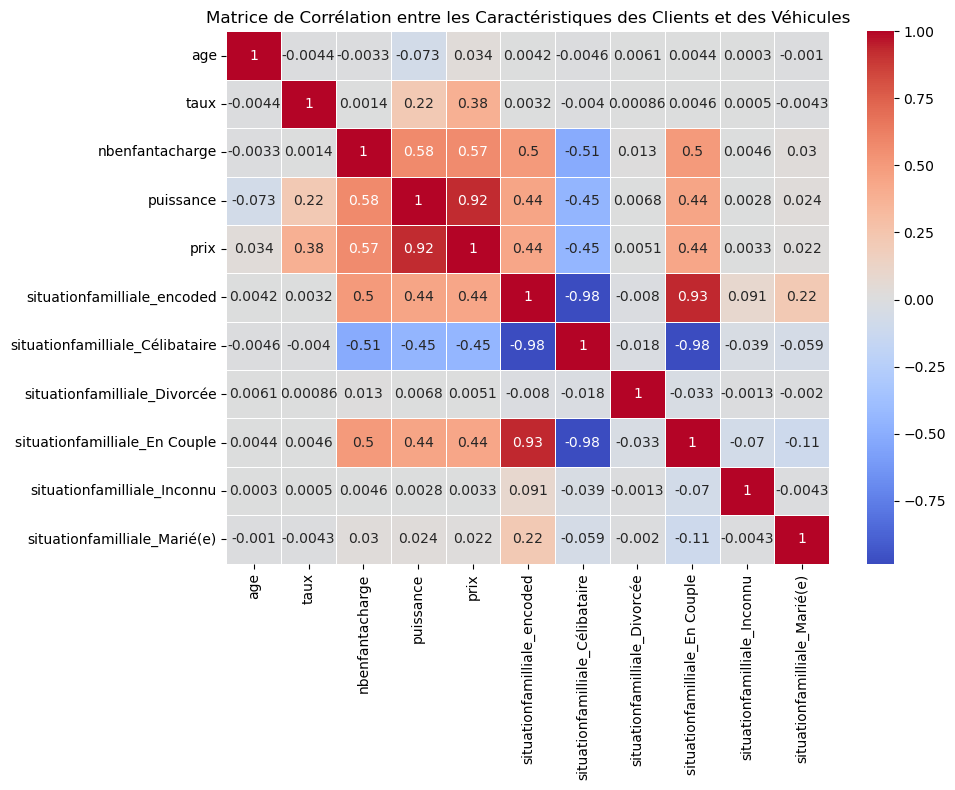

In [70]:
corr_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation entre les Caractéristiques des Clients et des Véhicules")
plt.tight_layout()
plt.show()

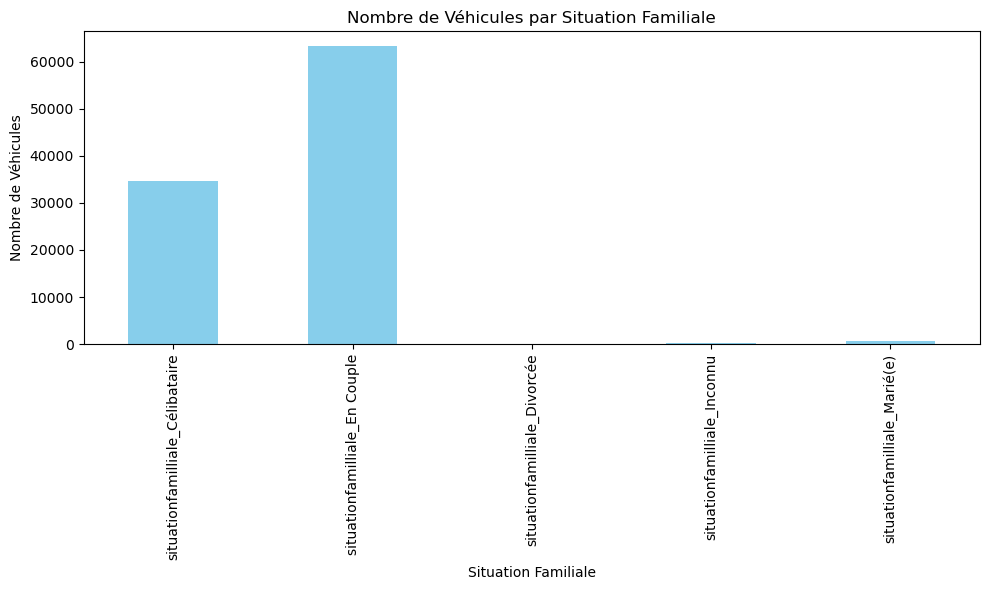

In [43]:
situation_counts = df_encoded[['situationfamilliale_Célibataire', 
                               'situationfamilliale_En Couple', 
                               'situationfamilliale_Divorcée', 
                               'situationfamilliale_Inconnu', 
                               'situationfamilliale_Marié(e)']].sum()

plt.figure(figsize=(10, 6))
situation_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Situation Familiale')
plt.ylabel('Nombre de Véhicules')
plt.title('Nombre de Véhicules par Situation Familiale')
plt.tight_layout()
plt.show()


Prix moyen des véhicules pour les hommes divorcés : 43272.3125
Prix moyen des véhicules pour les femmes divorcées : 42636.0390625


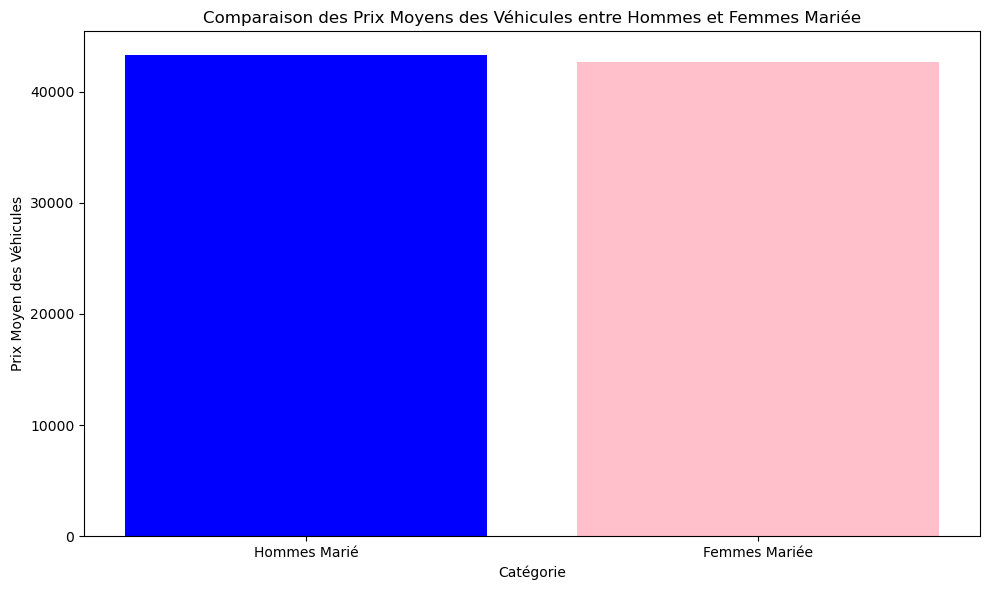

Prix moyen des véhicules pour les hommes divorcés : 44262.68359375
Prix moyen des véhicules pour les femmes divorcées : 34955.0


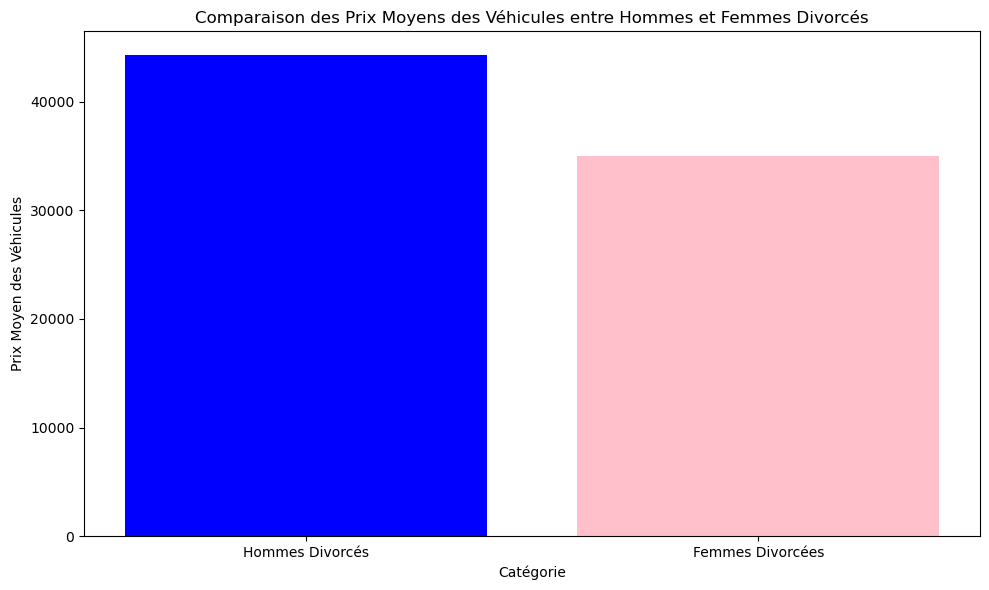

In [54]:
hommes_marie_df = client_immat_df.filter((client_immat_df.sexe == 'Homme') & (client_immat_df.situationfamilliale == 'Marié(e)'))
femmes_marie_df = client_immat_df.filter((client_immat_df.sexe == 'Femme') & (client_immat_df.situationfamilliale == 'Marié(e)'))

hommes_marie_df_pandas = hommes_marie_df.toPandas()
femmes_marie_df_pandas = femmes_marie_df.toPandas()

prix_moyen_hommes_marie = hommes_marie_df_pandas['prix'].mean()
prix_moyen_femmes_marie = femmes_marie_df_pandas['prix'].mean()

print(f"Prix moyen des véhicules pour les hommes divorcés : {prix_moyen_hommes_marie}")
print(f"Prix moyen des véhicules pour les femmes divorcées : {prix_moyen_femmes_marie}")

prix_moyens = [prix_moyen_hommes_marie, prix_moyen_femmes_marie]
categories = ['Hommes Marié', 'Femmes Mariée']

plt.figure(figsize=(10, 6))
plt.bar(categories, prix_moyens, color=['blue', 'pink'])
plt.xlabel('Catégorie')
plt.ylabel('Prix Moyen des Véhicules')
plt.title('Comparaison des Prix Moyens des Véhicules entre Hommes et Femmes Mariée')
plt.tight_layout()
plt.show()


hommes_divorces_df = client_immat_df.filter((client_immat_df.sexe == 'Homme') & (client_immat_df.situationfamilliale == 'Divorcée'))
femmes_divorcees_df = client_immat_df.filter((client_immat_df.sexe == 'Femme') & (client_immat_df.situationfamilliale == 'Divorcée'))

hommes_divorces_pandas = hommes_divorces_df.toPandas()
femmes_divorcees_pandas = femmes_divorcees_df.toPandas()

prix_moyen_hommes_divorces = hommes_divorces_pandas['prix'].mean()
prix_moyen_femmes_divorcees = femmes_divorcees_pandas['prix'].mean()

print(f"Prix moyen des véhicules pour les hommes divorcés : {prix_moyen_hommes_divorces}")
print(f"Prix moyen des véhicules pour les femmes divorcées : {prix_moyen_femmes_divorcees}")

prix_moyens = [prix_moyen_hommes_divorces, prix_moyen_femmes_divorcees]
categories = ['Hommes Divorcés', 'Femmes Divorcées']

plt.figure(figsize=(10, 6))
plt.bar(categories, prix_moyens, color=['blue', 'pink'])
plt.xlabel('Catégorie')
plt.ylabel('Prix Moyen des Véhicules')
plt.title('Comparaison des Prix Moyens des Véhicules entre Hommes et Femmes Divorcés')
plt.tight_layout()
plt.show()



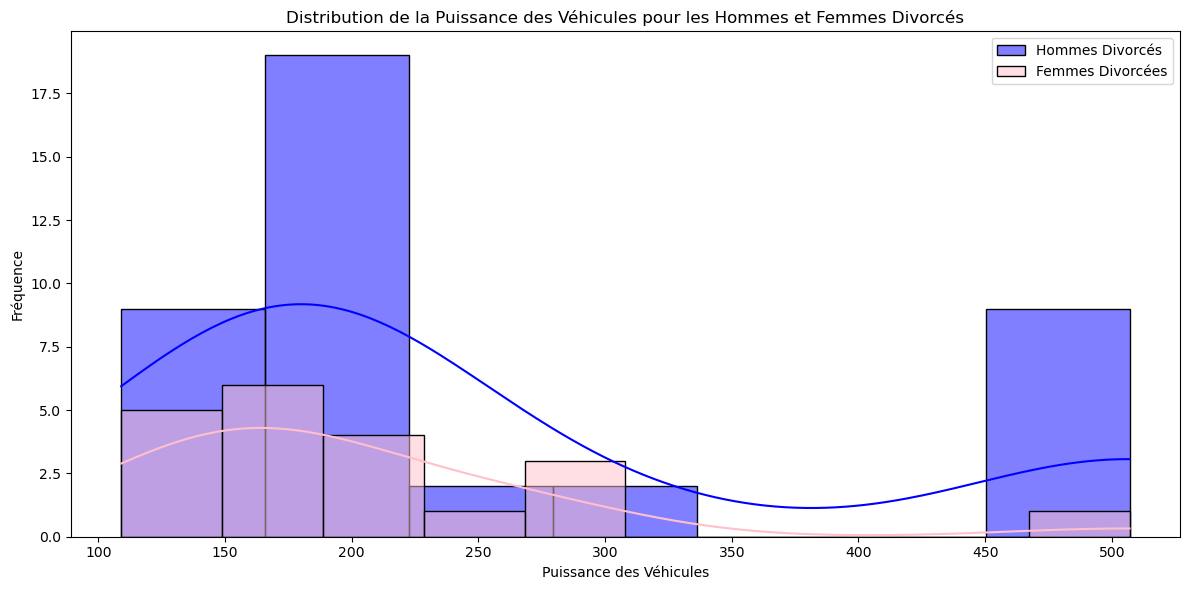

In [57]:
# Distribution de la puissance pour les hommes divorcés
plt.figure(figsize=(12, 6))
sns.histplot(hommes_divorces_pandas['puissance'], kde=True, color='blue', label='Hommes Divorcés')

# Distribution de la puissance pour les femmes divorcées
sns.histplot(femmes_divorcees_pandas['puissance'], kde=True, color='pink', label='Femmes Divorcées')

plt.xlabel('Puissance des Véhicules')
plt.ylabel('Fréquence')
plt.title('Distribution de la Puissance des Véhicules pour les Hommes et Femmes Divorcés')
plt.legend()
plt.tight_layout()
plt.show()


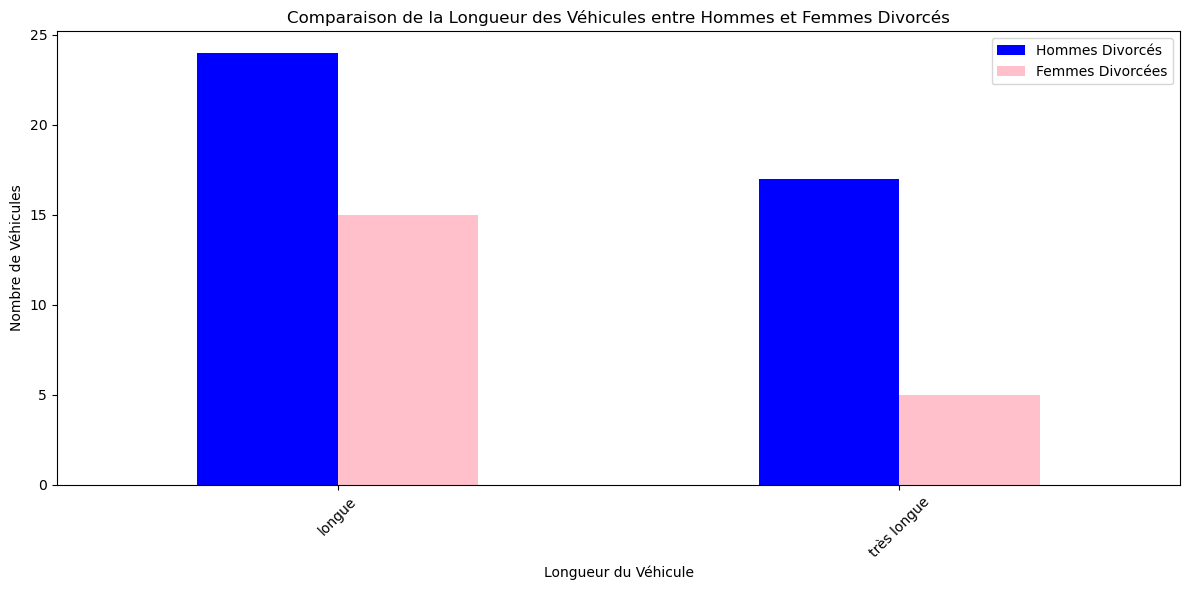

In [48]:
# Compter les catégories de longueur pour hommes divorcés
longueur_hommes = hommes_divorces_pandas['longueur'].value_counts()

# Compter les catégories de longueur pour femmes divorcées
longueur_femmes = femmes_divorcees_pandas['longueur'].value_counts()

# Créer un DataFrame pour visualisation
df_longueur = pd.DataFrame({'Hommes Divorcés': longueur_hommes, 'Femmes Divorcées': longueur_femmes}).fillna(0)

# Visualisation
df_longueur.plot(kind='bar', figsize=(12, 6), color=['blue', 'pink'])
plt.xlabel('Longueur du Véhicule')
plt.ylabel('Nombre de Véhicules')
plt.title('Comparaison de la Longueur des Véhicules entre Hommes et Femmes Divorcés')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


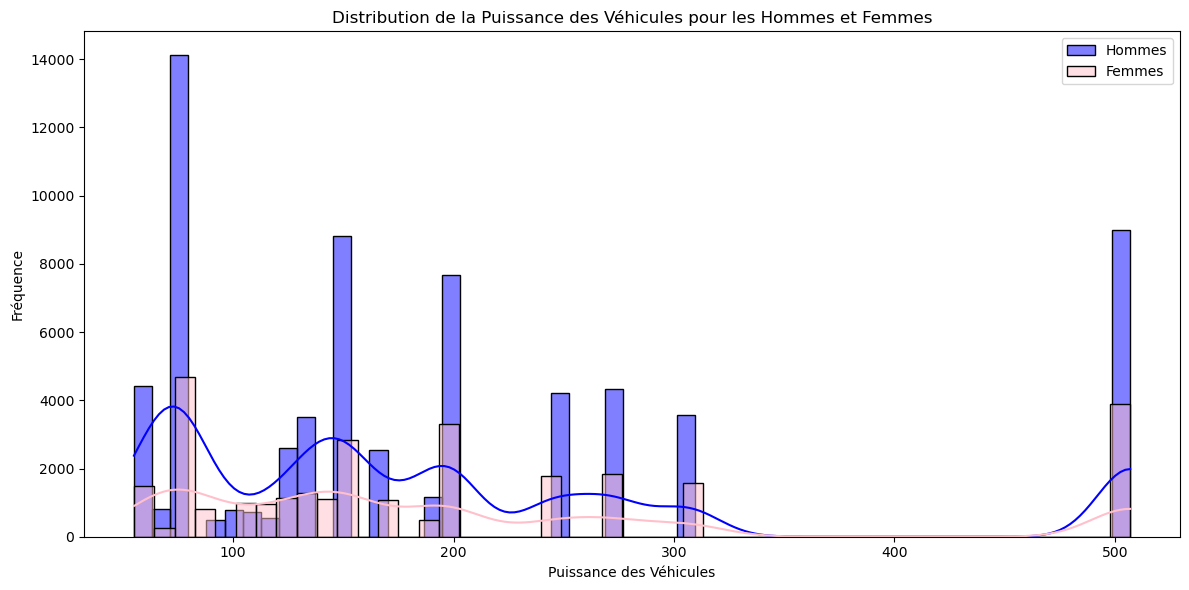

In [73]:
hommes_df = client_immat_df.filter(client_immat_df.sexe == 'Homme')
femmes_df = client_immat_df.filter(client_immat_df.sexe == 'Femme')

hommes_pandas = hommes_df.toPandas()
femmes_pandas = femmes_df.toPandas()

plt.figure(figsize=(12, 6))

sns.histplot(hommes_pandas['puissance'], kde=True, color='blue', label='Hommes', alpha=0.5)
sns.histplot(femmes_pandas['puissance'], kde=True, color='pink', label='Femmes', alpha=0.5)

plt.xlabel('Puissance des Véhicules')
plt.ylabel('Fréquence')
plt.title('Distribution de la Puissance des Véhicules pour les Hommes et Femmes')
plt.legend()
plt.tight_layout()
plt.show()
